# Quickstart: Target x Survey

learn how to merge target inside a survey and simulate a dataset (observed version of target's data)

In [1]:
from skysurvey import survey, target

/Users/rigault/miniforge3/lib/python3.9/site-packages/ztfquery-1.19.1-py3.9.egg/ztfquery/utils/tools.py:78: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray([v[0]*np.cos(theta*_DEG2RA) - v[2]*np.sin(theta*_DEG2RA),


Following what we learned in Quickstart: target, let's create a SNeIa dataset of 5 000 targets

### Target | data given by nature

In [2]:
%%time
snia = target.SNeIa.from_draw(500)

CPU times: user 105 ms, sys: 9.1 ms, total: 114 ms
Wall time: 113 ms


let's check when "nature started"

In [3]:
starting_date = snia.data["t0"].min()-50 # 50 days before the first target, no need to simulate a survey before that

### Survey | What has been observed when and how. Here ZTF case

In [4]:
%%time
ztf = survey.ZTF.from_random(size=365*2*500, # number of observation  2 years, 500 per day, small for the doc
                     bands=["ztfg","ztfr","ztfi"], # band to observed
                     mjd_range=[starting_date, starting_date+365*4], # timerange of observation
                     skynoise_range=[10,20], # sky noise
                     )

CPU times: user 375 ms, sys: 37.2 ms, total: 412 ms
Wall time: 411 ms


### Target in Survey | let's check which target belongs to which field.

This is particularly optiomized thanks to a combination of shapely, pandas and geopandas

In [5]:
%%time
fieldid_of_targets = ztf.radec_to_fieldid(*snia.data[["ra","dec"]].values.T)

CPU times: user 96.7 ms, sys: 2.81 ms, total: 99.5 ms
Wall time: 102 ms


In [6]:
fieldid_of_targets

index_radec
0            [1889, 874]
1      [1834, 829, 1859]
2            [609, 1654]
3       [771, 1807, 803]
4            [1307, 315]
             ...        
495          [381, 1426]
496    [1354, 362, 1406]
497          [514, 1508]
498     [572, 571, 1567]
499          [1538, 492]
Name: fieldid, Length: 499, dtype: object

### DataSet | The object that exploite the target x survey combination.

In [7]:
from skysurvey import DataSet

this not only match then SN with the target but already simulate the obseving point. 

In [8]:
%%time
dset = DataSet.from_targets_and_survey(snia, ztf)

CPU times: user 2.92 s, sys: 184 ms, total: 3.11 s
Wall time: 3.12 s


In [9]:
dset.data

fieldid          time  band       flux    fluxerr    zp zpsys
0   0       1634  60202.547250  ztfi -17.630831  12.885751  25.0    ab
    1       1634  60209.519592  ztfi   6.734005  17.697652  25.0    ab
    2       1634  60214.536581  ztfr -23.603692  17.212283  25.0    ab
    3       1634  60223.346646  ztfg  11.628628  10.428724  25.0    ab
    4       1634  60223.889017  ztfr -10.949704  16.725492  25.0    ab
...          ...           ...   ...        ...        ...   ...   ...
498 209     1424  61621.617909  ztfi  17.613123  17.177373  25.0    ab
    210     1424  61640.130176  ztfg -24.355185  19.809705  25.0    ab
    211     1424  61648.902346  ztfi   0.745269  18.472136  25.0    ab
    212     1424  61652.950660  ztfg  18.452039  17.785061  25.0    ab
    213     1424  61655.064544  ztfi  -8.593325  15.680207  25.0    ab

[230889 rows x 7 columns]

z         0.145500
x1       -0.839000
c        -0.012000
t0    60249.357479
x0        0.000189
Name: 90, dtype: float64

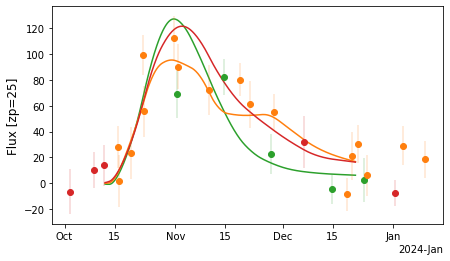

In [10]:
_ = dset.show_target_lightcurve(index=90, phase_window=[-30, 70])
dset.targets.get_template_parameters(index=90)

In [11]:
%%time
dset.get_ndetection(per_band=True)

CPU times: user 39.7 ms, sys: 25.7 ms, total: 65.3 ms
Wall time: 65.4 ms


level_0  band
0        ztfg    0
         ztfi    2
         ztfr    1
1        ztfg    3
         ztfi    3
                ..
498      ztfi    6
         ztfr    6
499      ztfg    0
         ztfi    0
         ztfr    0
Name: detected, Length: 1497, dtype: int64

***